## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [29]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [30]:
train, test = keras.datasets.cifar10.load_data()

In [31]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [32]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [33]:
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [34]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.90
L1_EXP = 1e-4
L2_EXP = 1e-4
opt_SGD = keras.optimizers.SGD(nesterov=True, momentum=MOMENTUM)
opt_Adam  = keras.optimizers.Adam()
optimizers = {"SGD" : opt_SGD, "Adam" : opt_Adam}

In [35]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for lr, opt_name in itertools.product(LEARNING_RATE, optimizers.keys()):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.4f opt = %s L1 = %s L2 = %s" % (lr, opt_name, L1_EXP, L2_EXP))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=L1_EXP, l2_ratio=L2_EXP)
    model.summary()
    opt = optimizers[opt_name]
    opt.learning_rate = lr
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-lr-%s-%s" % (str(lr), opt_name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.0100 opt = SGD L1 = 0.0001 L2 = 0.0001
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_______________________________________________________________

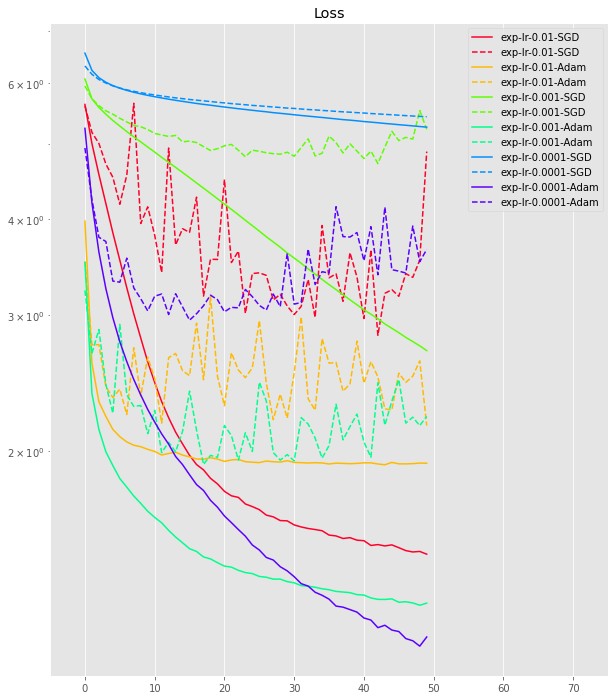

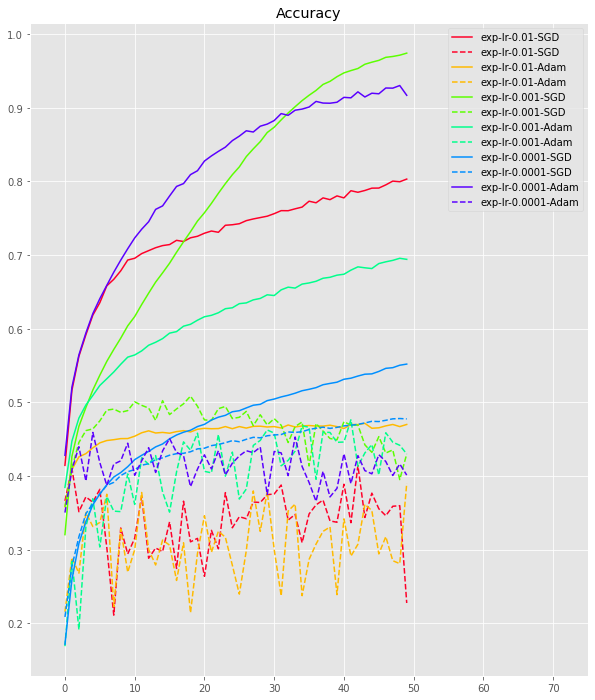

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
"""Code Here
將結果繪出
"""
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.xlim((-5,75))
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(10,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.xlim((-5,75))
plt.legend()
plt.show()